# Clustering for tevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class',  'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/tevsimbad_TeVspectrum_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,...,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,0.0,0.000000,0.000000,0.000060,0.000000,0.000143,0.001702,0.003243,0.007779,0.0,...,0.484812,0.272675,0.056902,0.037315,0.135368,b'UCAC4 105-013663',Be,b'',b'other',0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000338,0.019565,0.869940,0.0,...,0.045760,0.029010,0.025940,0.008455,0.000992,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.002454,0.616424,0.0,...,0.148664,0.120621,0.081368,0.027734,0.002726,b'SSTGC 519103',Be,b'',b'unid',0
3,0.0,0.027707,0.045983,0.000000,0.000000,0.000000,0.132615,0.170842,0.205397,0.0,...,0.003439,0.230194,0.136930,0.045784,0.001110,b'RMC 141',B,b'',b'pwn',0
4,0.0,0.000531,0.000618,0.000343,0.000474,0.000618,0.000385,0.000260,0.000244,0.0,...,0.489456,0.275287,0.057447,0.037672,0.136665,b'[AAA97b] J053648.7-691700',B,b'',b'other',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [7]:
def build_images(TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300, 
                 spectra=spectra, spectrum_columns=spectrum_columns):
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=TSNE_learning_rate, n_iter=TSNE_n_iter)
    spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=TSNE_learning_rate2)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(n, spectra=spectra, spectrum_columns=spectrum_columns):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


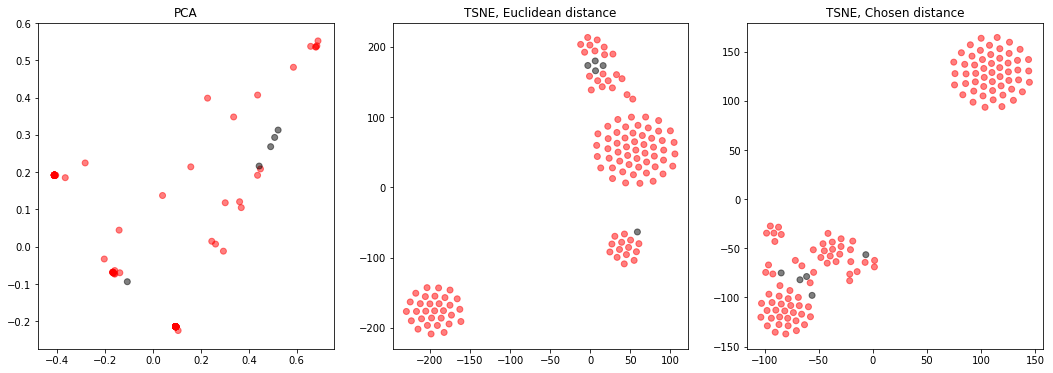

Clustering


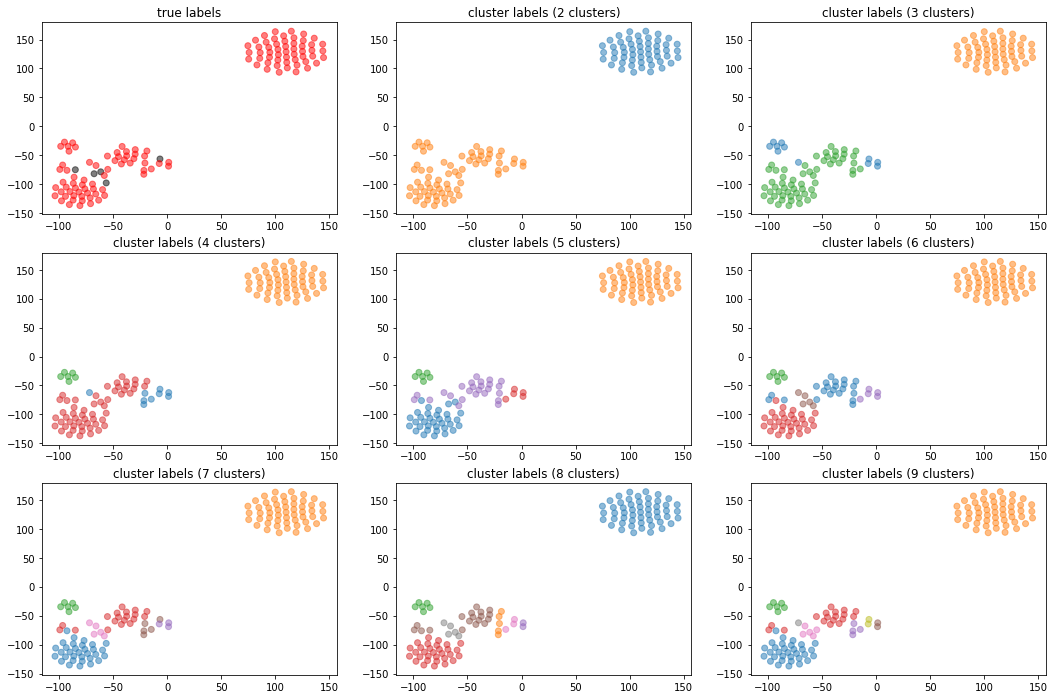

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
9,b'HTR 13',B,b'',b'pwn',0
10,b'LS IV -05 11',B,b'',b'unid',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0
28,b'OGLE LMC-ECL-21065',B0Ve,b'',b'pwn',0


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
3,b'RMC 141',B,b'',b'pwn',0
16,b'CPD-69 416',B,b'',b'other',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
91,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856',b'bin',1
117,b'Brey 84',B0Ve,b'',b'pwn',0


5 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
23,b'GCIRS 8',O,b'',b'unid',0
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
93,b'SN 2004am',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.005480,0.009346,0.020412,0.000690,0.041119,0.003520,0.040875,0.068519,0.124058,0.0,0.000013,0.000097,0.000323,0.0,0.305008,0.208047,0.065719,0.031427,0.075349
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079,0.015125,0.955688,0.0,0.000000,0.000000,0.000000,0.0,0.011160,0.007813,0.006451,0.002625,0.001060
3,0.000023,0.000147,0.000289,0.000108,0.000460,0.000180,0.009641,0.019904,0.034482,0.0,0.000000,0.000000,0.000000,0.0,0.007707,0.515444,0.306609,0.102519,0.002485
4,0.000000,0.023564,0.032294,0.000000,0.000000,0.024354,0.130946,0.170236,0.222114,0.0,0.000000,0.000000,0.000000,0.0,0.063551,0.132081,0.081588,0.051620,0.067650
5,0.000878,0.000344,0.001111,0.000214,0.000000,0.002077,0.090673,0.216631,0.554352,0.0,0.000050,0.000524,0.001696,0.0,0.051286,0.041600,0.028059,0.009564,0.000940


In [8]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(500, 1500, 600)
print_clusters_structure(6)

* ### euclidean distance

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


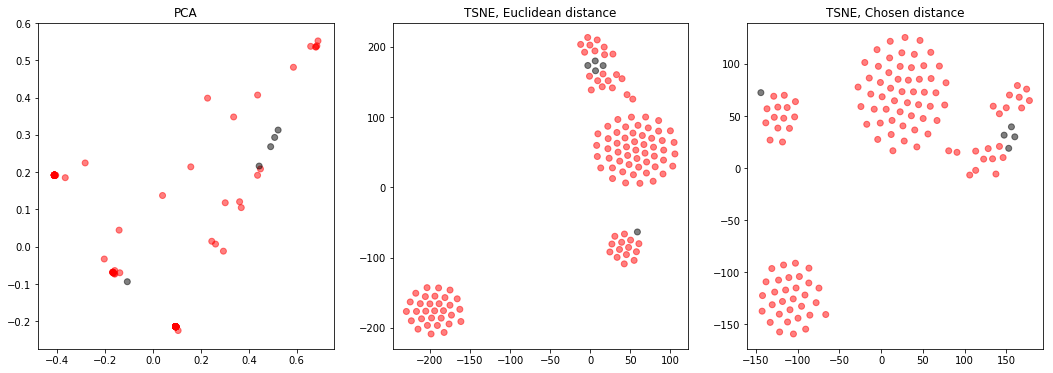

Clustering


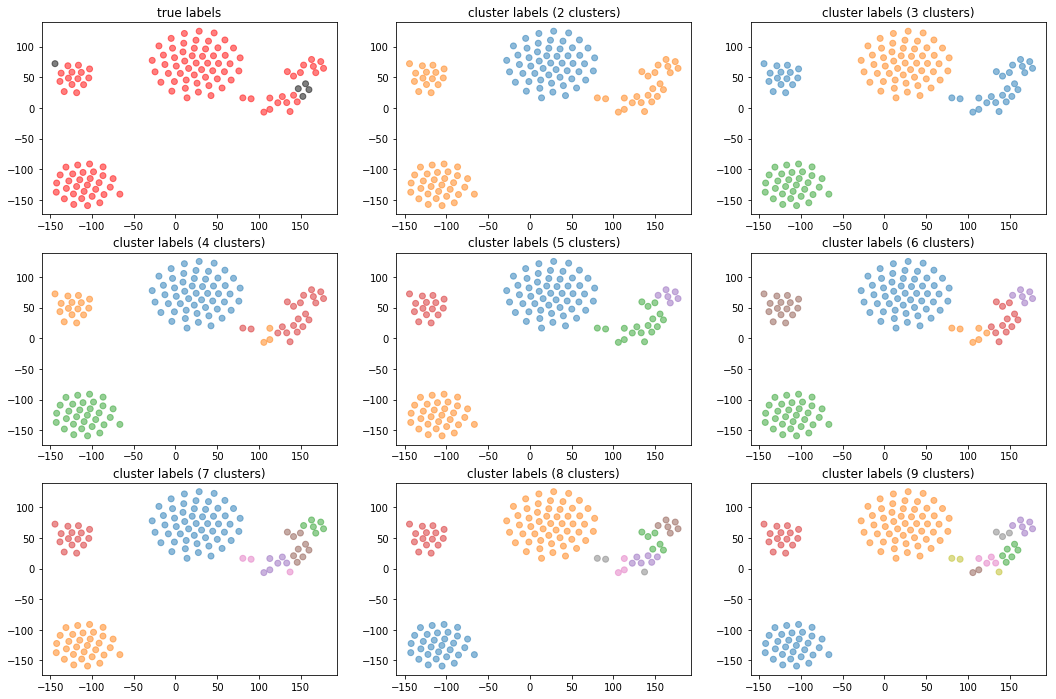

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
3,b'RMC 141',B,b'',b'pwn',0
9,b'HTR 13',B,b'',b'pwn',0
16,b'CPD-69 416',B,b'',b'other',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
108,b'CXOM82 J095538.3+694030',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
117,b'Brey 84',B0Ve,b'',b'pwn',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
10,b'LS IV -05 11',B,b'',b'unid',0
23,b'GCIRS 8',O,b'',b'unid',0
30,b'HD 43582',B0Ve,b'',b'snr',0
36,b'[MT91] 213',B0Ve,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
48,b'Schulte 21',B0Ve,b'',b'unid',0
59,b'LS I +61 303',B0Ve,b'',b'bin',1
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


5 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.007903,0.049289,0.083741,0.001649,0.148953,0.020981,0.122714,0.168122,0.226808,0.0,0.000000,0.000000,0.000000,0.0,0.011563,0.087863,0.050019,0.017115,0.003282
2,0.000015,0.000147,0.000251,0.000012,0.000038,0.000041,0.000732,0.001259,0.004346,0.0,0.000000,0.000000,0.000000,0.0,0.008182,0.547648,0.325766,0.108924,0.002640
3,0.003468,0.001561,0.004561,0.000680,0.001127,0.006577,0.128136,0.248499,0.509386,0.0,0.000045,0.000397,0.001298,0.0,0.022777,0.038164,0.024170,0.008383,0.000771
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079,0.015125,0.955688,0.0,0.000000,0.000000,0.000000,0.0,0.011160,0.007813,0.006451,0.002625,0.001060
5,0.002415,0.000724,0.004027,0.000086,0.000726,0.000617,0.001284,0.003263,0.007121,0.0,0.000000,0.000000,0.000000,0.0,0.462309,0.265161,0.074444,0.046532,0.131291


In [9]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(500, 1500, 500)
print_clusters_structure(6)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


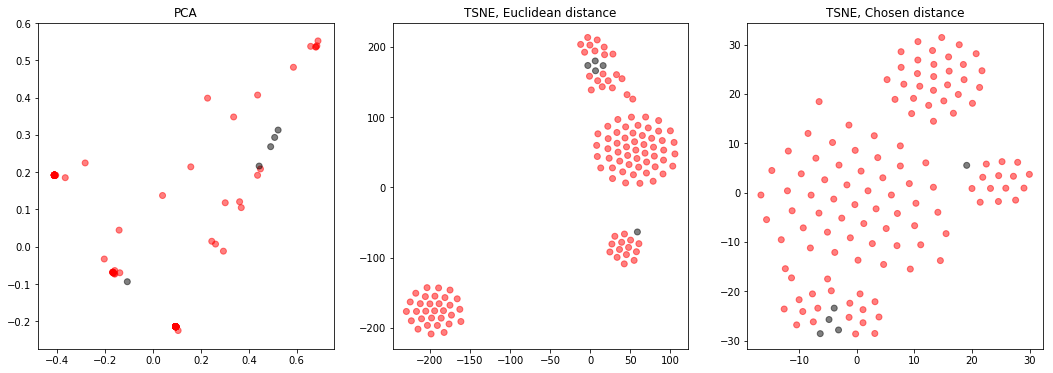

Clustering


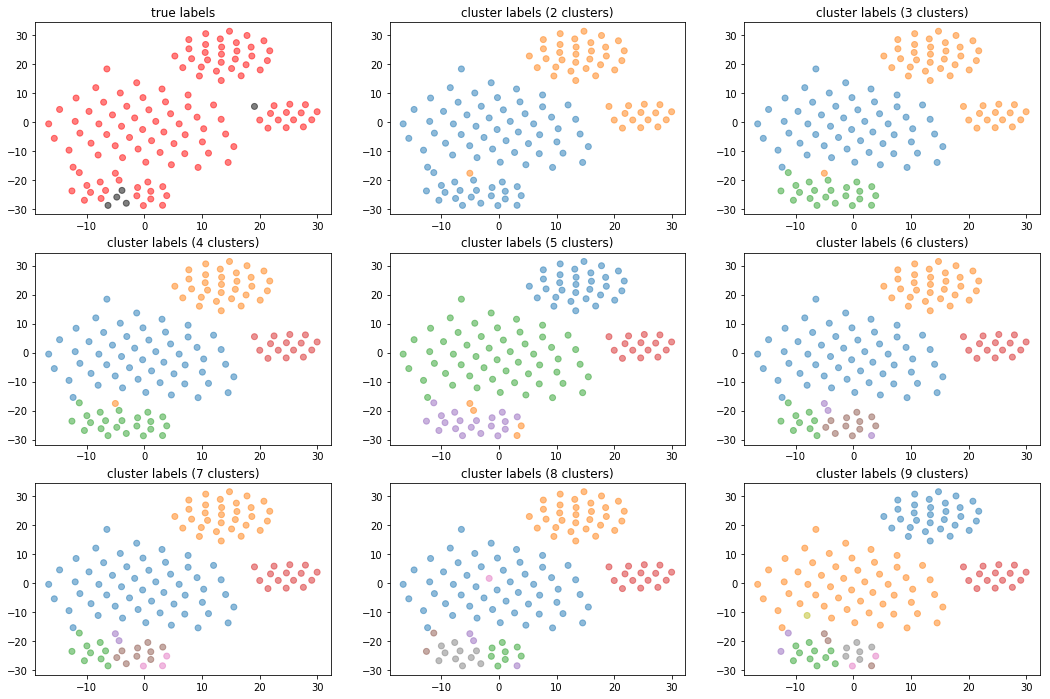

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
9,b'HTR 13',B,b'',b'pwn',0
10,b'LS IV -05 11',B,b'',b'unid',0
16,b'CPD-69 416',B,b'',b'other',0
30,b'HD 43582',B0Ve,b'',b'snr',0
36,b'[MT91] 213',B0Ve,b'',b'unid',0
48,b'Schulte 21',B0Ve,b'',b'unid',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
93,b'SN 2004am',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
114,b'V* V479 Sct',B0Ve,b'',b'bin',1


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
3,b'RMC 141',B,b'',b'pwn',0
117,b'Brey 84',B0Ve,b'',b'pwn',0


5 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
59,b'LS I +61 303',B0Ve,b'',b'bin',1
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


6 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
23,b'GCIRS 8',O,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.000823,3.276893e-03,6.244001e-03,0.000000,0.008175,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000015,1.471771e-04,2.507795e-04,0.000012,0.000038,0.000041,0.000732,0.001259,0.004346,0.0,0.000000,0.000000,0.000000,0.0,0.008182,0.547648,0.325766,0.108924,0.002640
2,0.004438,1.199562e-02,1.821026e-02,0.001543,0.050255,0.019900,0.187106,0.319116,0.352034,0.0,0.000032,0.000238,0.000788,0.0,0.008479,0.013828,0.006845,0.002849,0.002343
3,0.002415,7.237695e-04,4.026665e-03,0.000086,0.000726,0.000617,0.001284,0.003263,0.007121,0.0,0.000000,0.000000,0.000000,0.0,0.462309,0.265161,0.074444,0.046532,0.131291
4,0.000000,1.385363e-02,2.485630e-02,0.000000,0.000000,0.006689,0.118149,0.181289,0.273178,0.0,0.000000,0.000000,0.000000,0.0,0.003147,0.210634,0.125295,0.041894,0.001015
5,0.000516,2.044698e-04,7.100282e-04,0.000463,0.001503,0.001369,0.039347,0.092942,0.842224,0.0,0.000028,0.000291,0.000942,0.0,0.007476,0.005217,0.004306,0.001751,0.000709
6,0.000000,9.565200e-08,8.663528e-08,0.000000,0.000000,0.000000,0.000003,0.003457,0.637642,0.0,0.000000,0.000000,0.000000,0.0,0.086592,0.146448,0.092641,0.031279,0.001939


In [10]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(500, 1500, 400)
print_clusters_structure(7)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


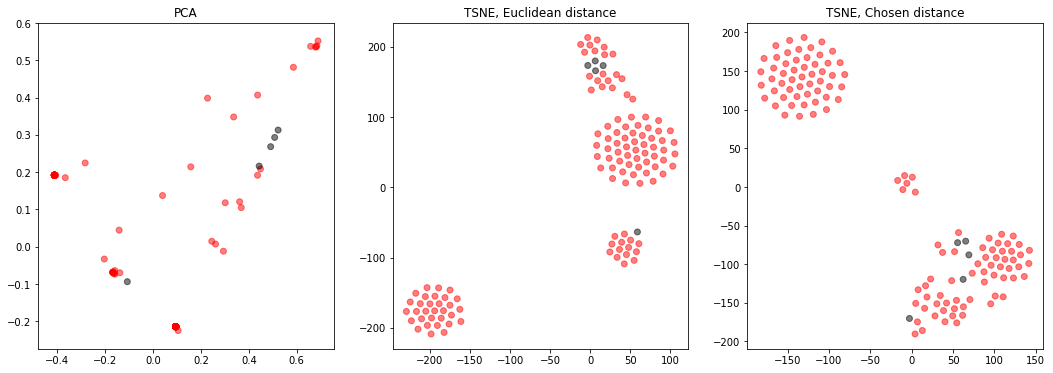

Clustering


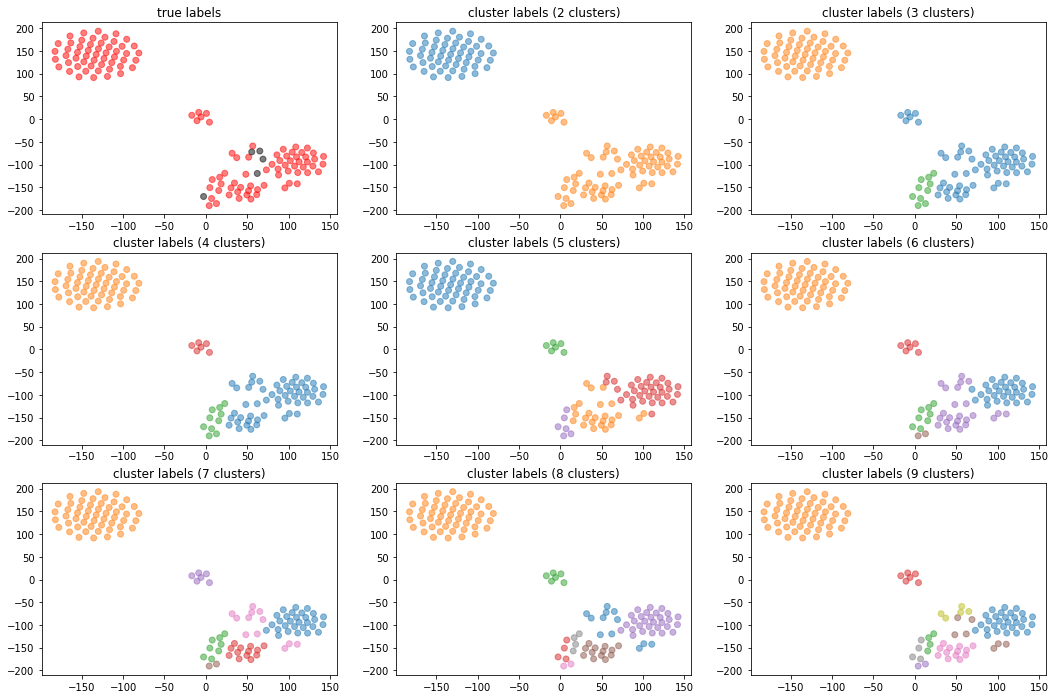

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
2,b'SSTGC 519103',Be,b'',b'unid',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
9,b'HTR 13',B,b'',b'pwn',0
10,b'LS IV -05 11',B,b'',b'unid',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0
28,b'OGLE LMC-ECL-21065',B0Ve,b'',b'pwn',0


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
3,b'RMC 141',B,b'',b'pwn',0
16,b'CPD-69 416',B,b'',b'other',0
43,b'[M2002] LMC 164299',B0Ve,b'',b'other',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
91,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856',b'bin',1
117,b'Brey 84',B0Ve,b'',b'pwn',0


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.004116,0.008547,0.018701,0.000632,0.037345,0.002970,0.037597,0.063212,0.169922,0.0,0.000012,0.000089,0.000296,0.0,0.271731,0.210363,0.076720,0.033644,0.064103
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079,0.015125,0.955688,0.0,0.000000,0.000000,0.000000,0.0,0.011160,0.007813,0.006451,0.002625,0.001060
3,0.000151,0.000076,0.000272,0.000133,0.000433,0.000474,0.022016,0.050000,0.073973,0.0,0.000007,0.000077,0.000249,0.0,0.007029,0.469880,0.279506,0.093457,0.002265
4,0.003631,0.020360,0.027878,0.000000,0.001387,0.021321,0.110832,0.143601,0.186970,0.0,0.000000,0.000000,0.000000,0.0,0.128407,0.152502,0.076846,0.048824,0.077442


In [11]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(500, 1500, 750)
print_clusters_structure(5)

- ### mahalanobis
$$d(u, v) = \sqrt{(u-v)V^{-1}(u+v)^{T}}$$,
V - The inverse of the covariance matrix.

In [12]:
import scipy as sp
from scipy.spatial.distance import mahalanobis
spectra_ = spectra.drop_duplicates(spectrum_columns)
spectra_spectra = spectra_[spectra_['marked'] != -1]

spectra_no_zeros = spectra_.loc[(spectra_spectra!= 0).any(axis=1), :]
spectra_no_zeros2 = spectra_no_zeros.loc[:, (spectra_no_zeros != 0).any(axis=0)]
new_columns = [i for i in spectra_no_zeros2 if i in spectrum_columns]
covmx = spectra_no_zeros2[new_columns].cov()
invcovmx = sp.linalg.inv(covmx)

In [13]:
#func = lambda x, y : mahalanobis(x, y, invcovmx)

- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


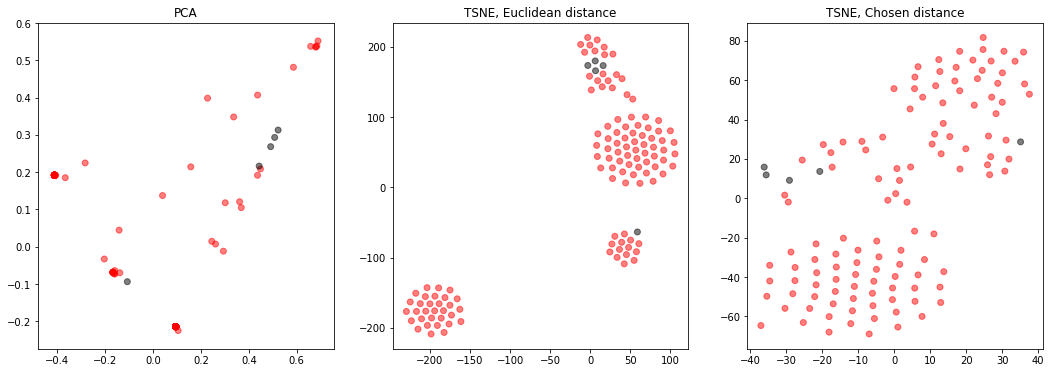

Clustering


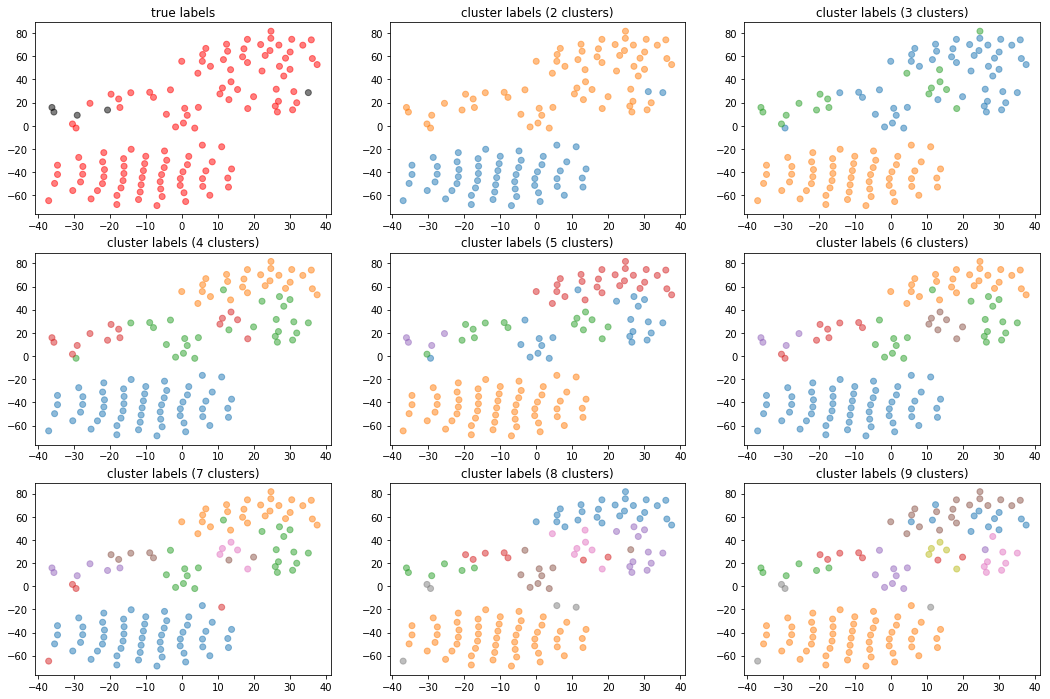

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,b'SSTGC 519103',Be,b'',b'unid',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
12,b'GCIRS 1W',B,b'',b'unid',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
22,b'[MCD2010] 18',O,b'',b'unid',0
23,b'GCIRS 8',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
24,b'[MCD2010] 13',O,b'',b'unid',0
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
3,b'RMC 141',B,b'',b'pwn',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
10,b'LS IV -05 11',B,b'',b'unid',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
16,b'CPD-69 416',B,b'',b'other',0
30,b'HD 43582',B0Ve,b'',b'snr',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
43,b'[M2002] LMC 164299',B0Ve,b'',b'other',0


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0
28,b'OGLE LMC-ECL-21065',B0Ve,b'',b'pwn',0


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
9,b'HTR 13',B,b'',b'pwn',0
59,b'LS I +61 303',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
114,b'V* V479 Sct',B0Ve,b'',b'bin',1


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.000636,0.000242,0.002418,0.000000,0.000000,0.000115,0.008197,0.019880,0.329684,0.0,0.000000,0.000000,0.000000,0.0,0.178104,0.241624,0.121600,0.049779,0.047722
1,0.000794,0.003160,0.006021,0.000000,0.007883,0.000000,0.003833,0.011524,0.020357,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.004193,0.009448,0.014748,0.000249,0.000726,0.013337,0.095583,0.138453,0.196112,0.0,0.000000,0.000000,0.000000,0.0,0.230634,0.161554,0.046223,0.024253,0.064486
3,0.000017,0.000173,0.000268,0.000014,0.000046,0.000049,0.000861,0.001448,0.005170,0.0,0.000000,0.000000,0.000000,0.0,0.008172,0.546984,0.325370,0.108792,0.002636
4,0.000978,0.000349,0.001691,0.003904,0.116456,0.002868,0.116313,0.243073,0.495002,0.0,0.000135,0.001191,0.003894,0.0,0.001920,0.006477,0.004023,0.001532,0.000197


In [14]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(5)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


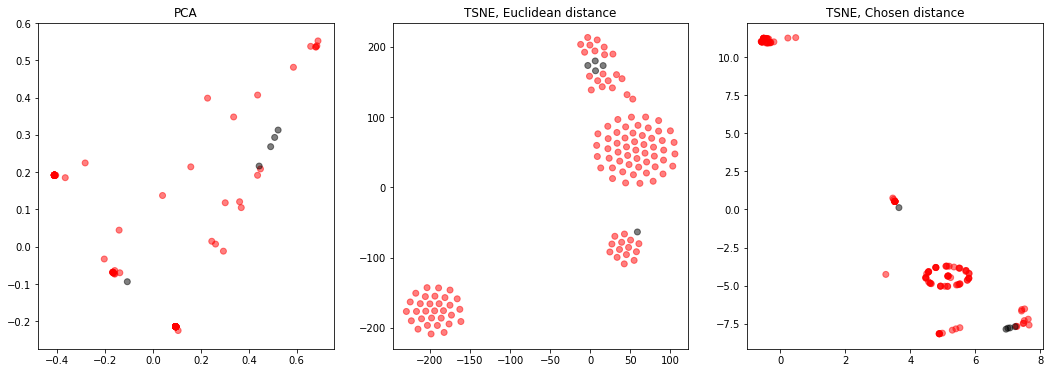

Clustering


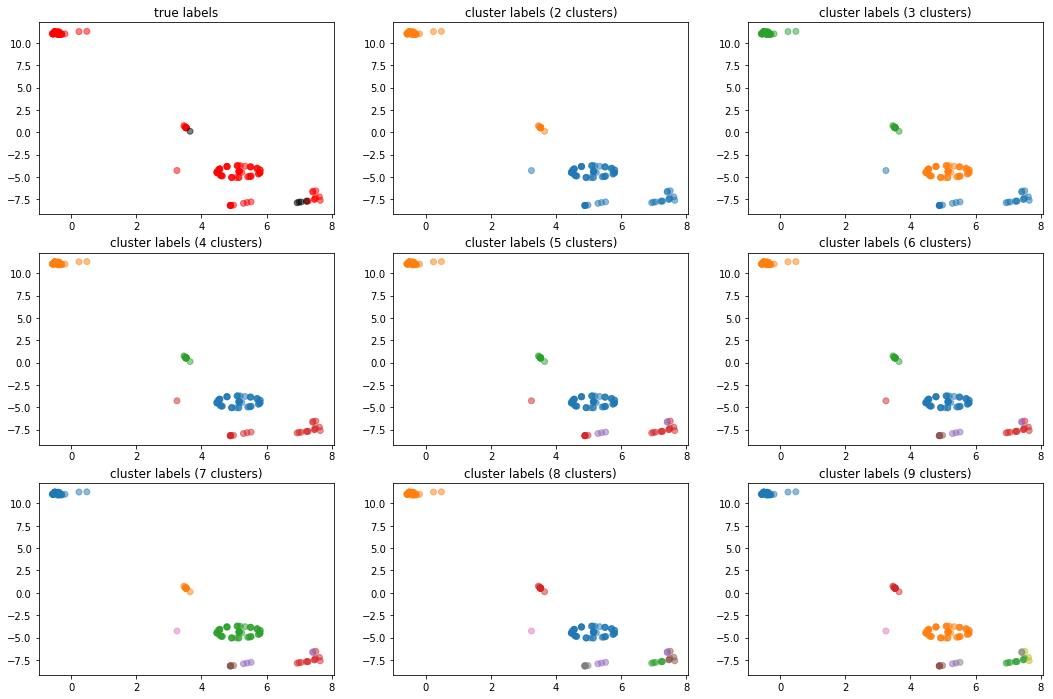

0 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
9,b'HTR 13',B,b'',b'pwn',0
10,b'LS IV -05 11',B,b'',b'unid',0
16,b'CPD-69 416',B,b'',b'other',0
30,b'HD 43582',B0Ve,b'',b'snr',0
36,b'[MT91] 213',B0Ve,b'',b'unid',0
48,b'Schulte 21',B0Ve,b'',b'unid',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
59,b'LS I +61 303',B0Ve,b'',b'bin',1
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
3,b'RMC 141',B,b'',b'pwn',0
23,b'GCIRS 8',O,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
117,b'Brey 84',B0Ve,b'',b'pwn',0


5 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


6 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
108,b'CXOM82 J095538.3+694030',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.000015,0.000147,0.000251,0.000012,0.000038,0.000041,0.000732,0.001259,0.004346,0.0,0.000000,0.000000,0.000000,0.0,0.008182,0.547648,0.325766,0.108924,0.002640
1,0.002415,0.000724,0.004027,0.000086,0.000726,0.000617,0.001284,0.003263,0.007121,0.0,0.000000,0.000000,0.000000,0.0,0.462309,0.265161,0.074444,0.046532,0.131291
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.003716,0.009150,0.014190,0.001504,0.038819,0.015952,0.169801,0.301481,0.417850,0.0,0.000045,0.000397,0.001298,0.0,0.006386,0.010377,0.005137,0.002138,0.001759
4,0.000000,0.005542,0.009943,0.000000,0.000000,0.002676,0.047261,0.074590,0.491856,0.0,0.000000,0.000000,0.000000,0.0,0.053214,0.172122,0.105702,0.035525,0.001569
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079,0.015125,0.955688,0.0,0.000000,0.000000,0.000000,0.0,0.011160,0.007813,0.006451,0.002625,0.001060
6,0.044448,0.176952,0.337176,0.000000,0.441423,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
plt.clf()
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(7)

- ### braycurtis 
$$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

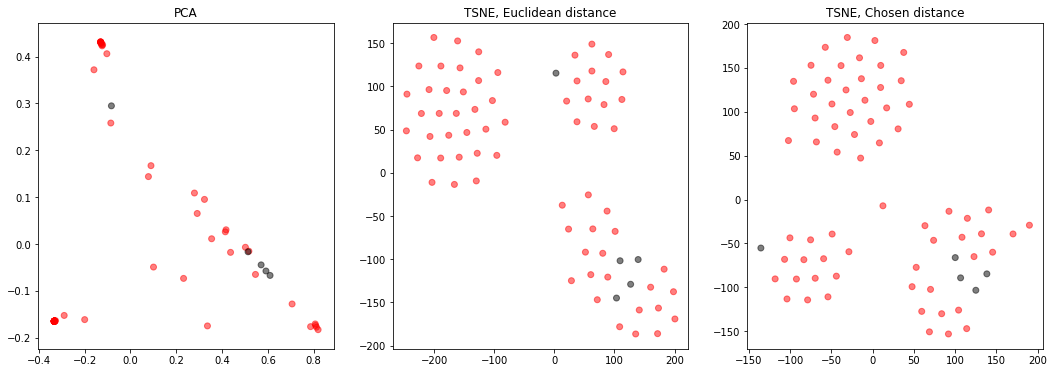

Clustering


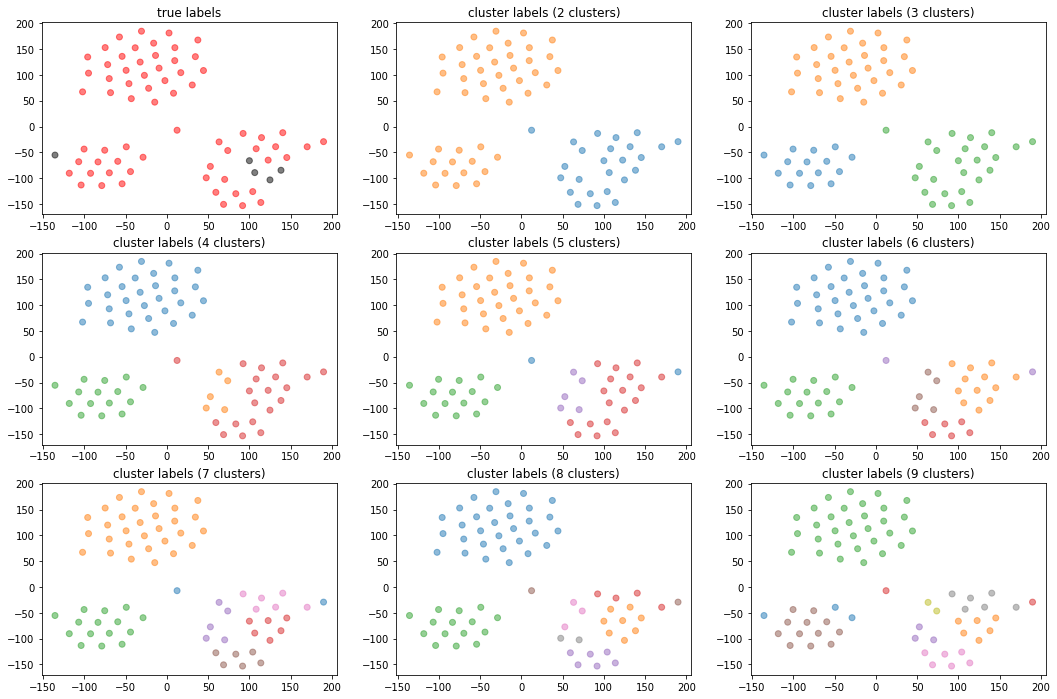

0 cluster


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
108,b'CXOM82 J095538.3+694030',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0


2 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0


3 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
36,b'[MT91] 213',B0Ve,b'',b'unid',0
48,b'Schulte 21',B0Ve,b'',b'unid',0
59,b'LS I +61 303',B0Ve,b'',b'bin',1
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
114,b'V* V479 Sct',B0Ve,b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
3,b'RMC 141',B,b'',b'pwn',0
23,b'GCIRS 8',O,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
117,b'Brey 84',B0Ve,b'',b'pwn',0


5 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


6 cluster


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
9,b'HTR 13',B,b'',b'pwn',0
10,b'LS IV -05 11',B,b'',b'unid',0
16,b'CPD-69 416',B,b'',b'other',0
30,b'HD 43582',B0Ve,b'',b'snr',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
93,b'SN 2004am',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


centroids:


,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_g,s_FLUX_r,s_FLUX_i,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.022224,0.088476,0.168588,0.000000,0.220712,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000015,0.000147,0.000251,0.000012,0.000038,0.000041,0.000732,0.001259,0.004346,0.00000,0.000000,0.000000,0.008182,0.547648,0.325766,0.108924,0.002640
2,0.002415,0.000724,0.004027,0.000086,0.000726,0.000617,0.001284,0.003263,0.007121,0.00000,0.000000,0.000000,0.462309,0.265161,0.074444,0.046532,0.131291
3,0.000828,0.000376,0.001554,0.001359,0.002255,0.003406,0.144321,0.287365,0.551716,0.00009,0.000794,0.002596,0.001235,0.000956,0.000682,0.000352,0.000115
4,0.000000,0.005542,0.009943,0.000000,0.000000,0.002676,0.047261,0.074590,0.491856,0.00000,0.000000,0.000000,0.053214,0.172122,0.105702,0.035525,0.001569
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079,0.015125,0.955688,0.00000,0.000000,0.000000,0.011160,0.007813,0.006451,0.002625,0.001060
6,0.006604,0.017924,0.026826,0.001649,0.075382,0.028498,0.195281,0.315597,0.283983,0.00000,0.000000,0.000000,0.011538,0.019799,0.009593,0.003924,0.003402


In [16]:
plt.clf()
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra_no_zeros2[new_columns], metric=metric_function)
try:
    build_images(spectra=spectra_no_zeros2, spectrum_columns=new_columns)
    print_clusters_structure(7, spectra_no_zeros2, new_columns)
except ValueError:
    print('Error in TSNE. May be caused by duplicates and zero rows')


- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

In [17]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra_no_zeros2[new_columns], metric=metric_function)
try:
    build_images(spectra=spectra_no_zeros2, spectrum_columns=new_columns)
    print_clusters_structure(7, spectra_no_zeros2, new_columns)
except ValueError:
    print('Error in TSNE. May be caused by duplicates and zero rows')


Error in TSNE. May be caused by duplicates and zero rows


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:647: RuntimeWarning: invalid value encountered in less
  if np.any(X < 0):
